<a href="https://colab.research.google.com/github/liquidx/ml/blob/main/Mobile_GANs_v2_2_Generate_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mobile Screen GAN V2.2 Generate Only

This is only for loading my Mobile Screen GAN v2.2 model which had a bug in it (only generates images between [0,1] rather than [-1, 1] range of colors.




## 1 Dependencies

In [3]:
!pip -q install datasets transformers pillow rich 

     |████████████████████████████████| 365 kB 7.6 MB/s 
     |████████████████████████████████| 4.7 MB 47.2 MB/s 
     |████████████████████████████████| 235 kB 55.8 MB/s 
     |████████████████████████████████| 101 kB 11.1 MB/s 
     |████████████████████████████████| 141 kB 53.8 MB/s 
     |████████████████████████████████| 115 kB 57.6 MB/s 
     |████████████████████████████████| 212 kB 53.7 MB/s 
     |████████████████████████████████| 596 kB 56.3 MB/s 
     |████████████████████████████████| 127 kB 52.1 MB/s 
     |████████████████████████████████| 6.6 MB 37.4 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 


In [4]:
import os
import numpy as np
import PIL
import PIL.Image
import pathlib
import pickle 
import time

from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

from datasets import load_dataset
from datasets import Image
from rich import inspect
from transformers import DataCollatorWithPadding


In [5]:
# Dependencies for Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model

# For subclassing
from tensorflow.keras.models import Model
# For ModelMonitor Callback
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


Google Colab specific initialization. This noteboook stores all checkpoints and results in Google Drive to avoid issues when the runtime is disconnected.

In [6]:
HAS_COLAB = False
try:
  import google.colab
  HAS_COLAB = True
except ImportError:
  pass


In [8]:
CHECKPOINTS_DIR = './checkpoints'
if HAS_COLAB:
  google.colab.drive.mount('/content/drive')
  CHECKPOINTS_DIR = '/content/drive/MyDrive/ML/checkpoints/mobilegan'


Mounted at /content/drive


## 2 Initialize

### Confirm GPUs

Confirm that there are some GPUs and the settings are set correctly so they don't run out of memory.

In [9]:
# Bringing in tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpus    

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Global training parameters

In [10]:
DEFAULT_RNG_SEED = 123  # Unused?

IMAGE_SIZE = (64, 32)

BATCH_SIZE = 128
BUFFER_SIZE = 50000 # Unused if loading from images_from_dir
PREFETCH_SIZE = 64 # Unused if loading frim images_from_dir

LATENT_DIM = 128


## 5 GAN Model

This section the GAN model is built, including the generator and discriminator along with some functions to help use the generator by providing it with the correct latent seeds.

### Image Generation

Methods to generate the generated images given the generator model.

In [11]:
def generate_latent_points(latent_dim, n_samples):
	"""Generate random points that will feed the generator."""
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(generator_model, latent_dim, img_count):
  """Generate some fake sample image data for the discriminator."""
  seed = generate_latent_points(latent_dim, img_count)
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  imgs = generator_model(seed, training=False)
  return imgs	

Methods for showing generated images from the generator model.

Both methods are available, but for exporting, `generate_and_show()` is cleaner and more scalable.

In [31]:
def scale_image_unit(img):
  """Convert numpy image data from [-1,1] to [0,1] range."""
  return np.maximum(np.zeros_like(img), img)

def generate_and_show_subplots(g_model, latent_dim, img_count=4):
  """Show generated imges using plt.subplots()."""
  imgs = generate_fake_samples(g_model, latent_dim, img_count)
  fig, ax = plt.subplots(ncols=img_count, figsize=(20, 10))
  for i, img in enumerate(imgs):
    ax[i].imshow(np.squeeze(scale_image_unit(img)))

def generate_and_show(g_model, latent_dim, epoch=0, rows=2, cols=4, scale=8, 
                      seed=None, output_dir=None):
  """
  Show generated images using plt.figure() & plt.subplot(). 
  Optionally allow saving the results to disk.
  """
  img_count = rows * cols
  if seed is None:
    seed = generate_latent_points(latent_dim, img_count)
  imgs = g_model(seed, training=False)
  fig = plt.figure(figsize=(cols * scale, rows * scale * 2))

  for i in range(imgs.shape[0]):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.squeeze(scale_image_unit(imgs[i])))
    plt.axis('off')

  if output_dir:
    path = os.path.join(output_dir, 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.savefig(path)
    
  plt.show()


### Checkpointing

`checkpoint_models()` defines what weights and optimizer config is saved. Checkpoint will pack everything into a single file which makes it convenient to manage. All paramaters passed, when restored will be directly applied to the passed models.

In [13]:
def checkpoint_models(g_model, d_model, g_opt, d_opt):
  return tf.train.Checkpoint(g_model=g_model,
                             d_model=d_model,
                             g_opt=g_opt,
                             d_opt=d_opt,)


To keep track of the epoch and losses, we save this separatly from `tf.train.Checkpoint`. Oddly `Checkpoint` doesn't have any capability to save the training history, so we have to do it manually here.

In [14]:
def save_training_history(history, history_path):
  with open(history_path, 'wb') as f:
    pickle.dump(history, f)
  return history

def load_training_history(history_path):
  if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
      return pickle.load(f)
  else:
    return []


### Model Definition

Model is primarily based on  [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/) and [DCGAN Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) along with some tips from Machine Learning Mastery on optimizing GANs.


Adding from build_generator_v2:
* batchnorm to stablize
* Changing activation to tanh
* Fix the kernel to be square

In [19]:
def build_generator_v2_2(latent_dim):
  """
  This generator is built to go from a `latent_dim` 
  random seed, to a 4x8, 8x16, 16x32 image.

  Note that the defintion array is set up as row, col.
  TODO: This might be a mistake??
  """
  model = Sequential()

  n = 256 
  rows = 8
  cols = 4
  n_nodes = n * rows * cols

  # First hidden layer has enough nodes to represent a low
  # rest version of the output image.
  model.add(Dense(n_nodes, input_dim=latent_dim))

  # Batch normalization to help stablize, but sometimes it can cause issues?
  # https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
  model.add(BatchNormalization(momentum=0.0))

  # LeakyReLU is recommended over ReLU, with a alpha of 0.2
  # https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((rows, cols, n)))

  # Upsample from 4x8 to 8x16
  # You can use UpSampling2D + Conv2D, or use Conv2DTranspose.
  # https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/
  model.add(Conv2DTranspose(n, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsample from 8x16 to 16x32
  model.add(Conv2DTranspose(n, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsample from 16x32 to 32x64
  model.add(Conv2DTranspose(n, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Output layer
  # Using tanh as the activation is the best for GANs
  # https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
  #
  # Note: tanh is returning values in the range [-1, 1]
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model


In [20]:
def build_discriminator_v2_2(in_shape=(64, 32, 3)):
  """Returns the discriminator for the GAN.

  Note: We do not compile the discriminator as in the tutorial this came from so
  that we construct the GAN model so there is a symmetry with build_generator().

  https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

  """
  model = Sequential()

  # Normal
  # Not really sure why it's using a 3x3 kernel.
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))

  # Downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Classifier
  model.add(Flatten())
  model.add(Dropout(0.4)) 
  model.add(Dense(1, activation='sigmoid'))
  return model

In [21]:
def create_gan_model_v2_2(latent_dim, 
                          g_opt_learning_rate=0.0001, 
                          d_opt_learning_rate=0.0001):
  """Create the GAN model.
  
  @return: (gan_model, generator, dicriminator, g_opt, d_opt)
  """
  # Generator itself has no optimizers (not sure why.)
  generator = build_generator_v2_2(latent_dim)

  # Discriminator has it's own optimizer and loss, this is compiled with
  # the metrics monitored as 'accuracy'.
  discriminator = build_discriminator_v2_2()
  d_opt = Adam(learning_rate=d_opt_learning_rate,  beta_1=0.5)
  d_loss = BinaryCrossentropy()
  discriminator.compile(loss=d_loss, optimizer=d_opt, metrics=['accuracy'])

  # Setting discriminator as not trainable is important so that
  # when optimizing the GAN it doesn't change the discriminator 
  # weights. We manually train it when feeding in real/fake images.
  discriminator.trainable = False

  # Create the GAN by combining both generator and the discriminator
  # into this sequential model. 
  # 
  # This is a very smart way to set up the GAN so we don't need to
  # manually do the back-propogation.
  gan_model = Sequential()
  gan_model.add(generator)
  gan_model.add(discriminator)
  g_opt = Adam(learning_rate=g_opt_learning_rate,  beta_1=0.5)
  g_loss = BinaryCrossentropy()
  gan_model.compile(loss=g_loss, optimizer=g_opt)

  return (gan_model, generator, discriminator, g_opt, d_opt)  

## 8. Train

The actual training steps. Up to now, the model has not be created. This section creates the model and starts the training.

Note, throughout the training of this GAN, we are using the outputs as:

 - Real Images : y_hat = 0
 - Fake Images : y_hat = 1



In [25]:
model_version = '2.2'
current_checkpoints_dir = os.path.join(CHECKPOINTS_DIR, f'model-v{model_version}')
current_history_path = os.path.join(CHECKPOINTS_DIR, f'model-v{model_version}-history.pkl')
current_samples_path = os.path.join(CHECKPOINTS_DIR, f'samples-v{model_version}')


## Inspection

Performance inspection

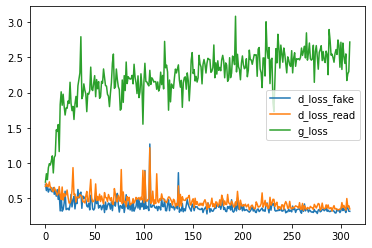

In [26]:
def plot_losses_v2():
  hist = load_training_history(current_history_path)
  plt.plot([h['d_loss_fake'] for h in hist], label='d_loss_fake')
  plt.plot([h['d_loss_real'] for h in hist], label='d_loss_read')
  plt.plot([h['g_loss'] for h in hist], label='g_loss')
  plt.legend()
  plt.show()

plot_losses_v2()

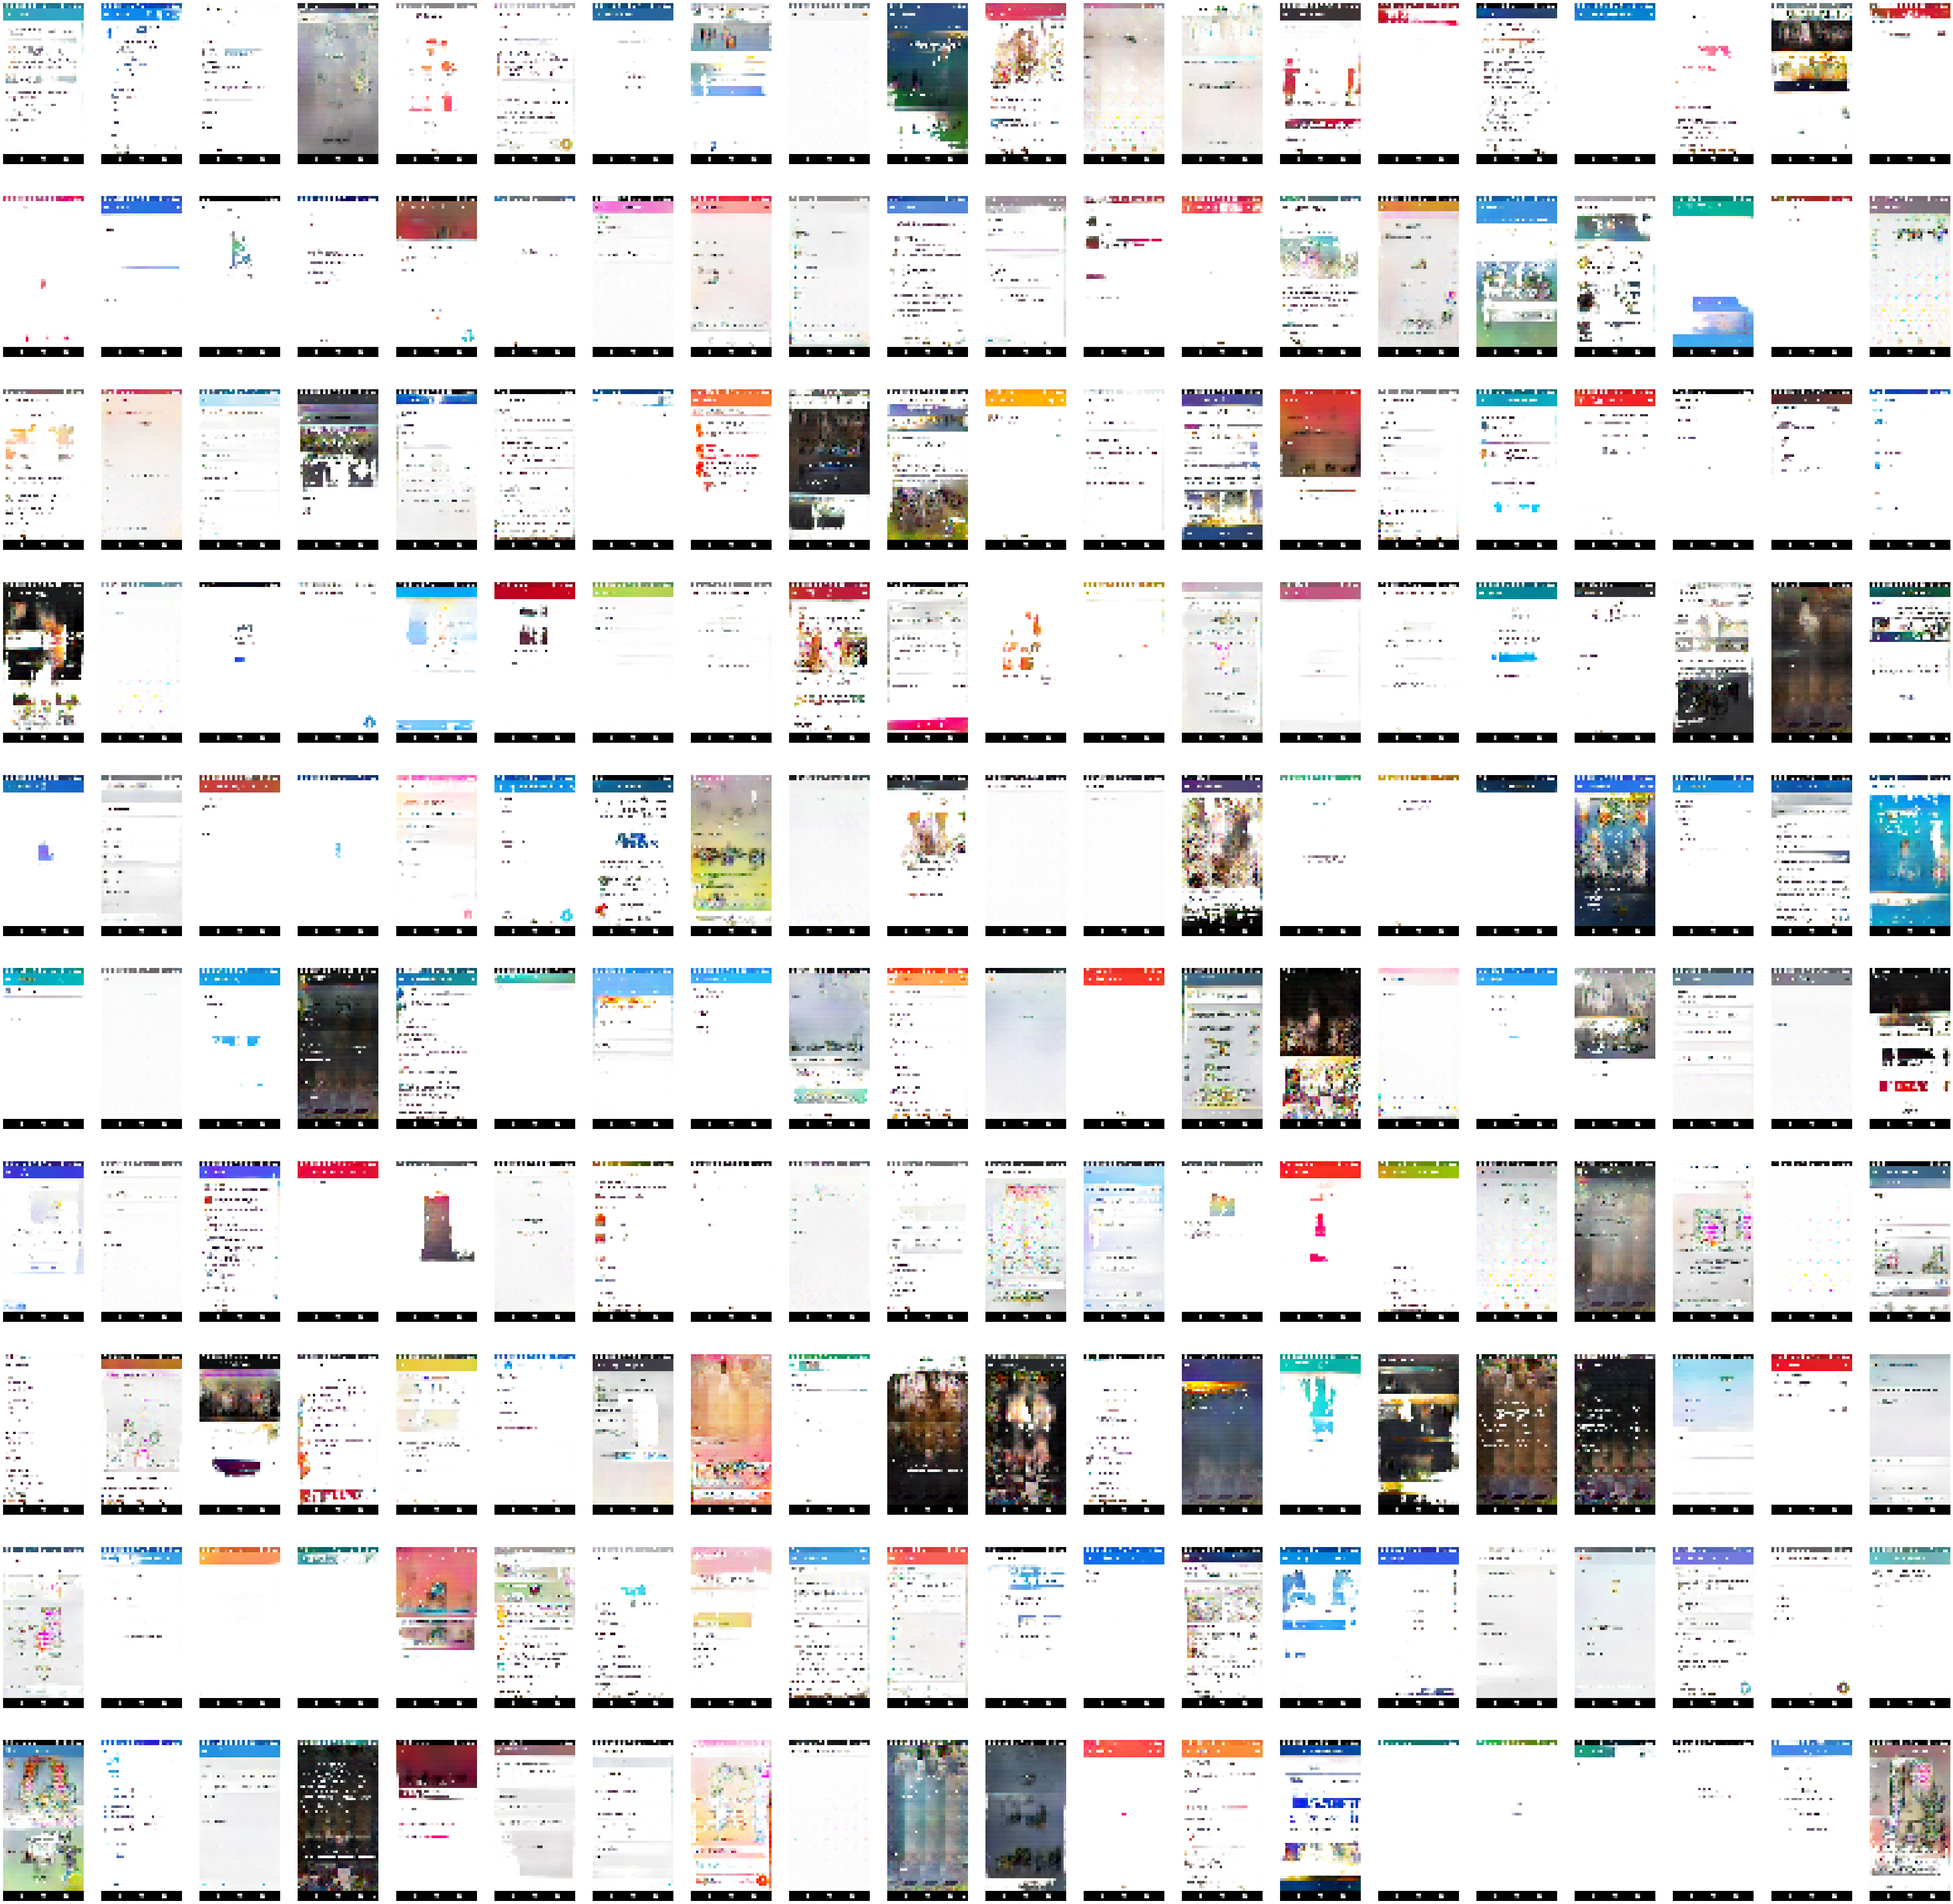

/content/drive/MyDrive/ML/checkpoints/mobilegan/model-v2.2


In [32]:
def test_model(checkpoint_dir):
  gan_model, g_model, d_model, g_opt, d_opt = create_gan_model_v2_2(LATENT_DIM)

  checkpoint = checkpoint_models(g_model, d_model, g_opt, d_opt)
  checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=current_checkpoints_dir, max_to_keep=5)
  checkpoint_manager.restore_or_initialize()  

  generate_and_show(g_model, LATENT_DIM, rows=10, cols=20, scale=4)

  # img_count = 4
  # imgs = generate_fake_samples(g_model, LATENT_DIM, img_count)
  # fig, ax = plt.subplots(ncols=img_count, figsize=(20, 10))
  # for i, img in enumerate(imgs):
  #   ax[i].imshow(np.squeeze(img))

test_model(current_checkpoints_dir)    
print(current_checkpoints_dir)